<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 7.57 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 11:43:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 16.0 MB/s 
     |████████████████████████████████| 138 kB 58.3 MB/s 
     |████████████████████████████████| 97 kB 7.8 MB/s 
     |████████████████████████████████| 133 kB 57.7 MB/s 
     |████████████████████████████████| 177 kB 58.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: oiyl5sm7
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/oiyl5sm7


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: wm6brmxf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 14s 89ms/step - loss: 2.3241 - mean_squared_error: 2.3241 - mean_absolute_error: 1.0456 - val_loss: 3.8275 - val_mean_squared_error: 3.8275 - val_mean_absolute_error: 1.9304
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 1.0101 - mean_squared_error: 1.0101 - mean_absolute_error: 0.7430 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1343
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1803 - val_loss: 0.1196 - val_mean_squared_error: 0.1196 - val_mean_absolute_error: 0.3261
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1731 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1488
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0109

wandb: Agent Starting Run: lwa6cyf4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - mean_absolute_error: 0.2738 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1496
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0769 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1078
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0562 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1060
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1003
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.

wandb: Agent Starting Run: kg60rpi0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.1307 - mean_squared_error: 0.1307 - mean_absolute_error: 0.2944 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1246
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1049 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1193
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0767 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1068
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0571 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1046
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_squared_erro

wandb: Agent Starting Run: ag23r4r5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.1902 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0983
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0672 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1096
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0745 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0861
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0604 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1043
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_squared_erro

wandb: Agent Starting Run: sp5bl566 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 1s 35ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - mean_absolute_error: 0.3644 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1118
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1331 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1390
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1197 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1195
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1007 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1156
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0125 - mean_squared_erro

wandb: Agent Starting Run: 1kxsrx5w with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 31ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0996 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1159
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0644 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1147
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0620 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1087
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0587 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1064
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nkdqyqi3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 40.9234 - mean_squared_error: 40.9234 - mean_absolute_error: 3.1967 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1272
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1503 - mean_squared_error: 0.1503 - mean_absolute_error: 0.2015 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0999
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 1.6925 - mean_squared_error: 1.6925 - mean_absolute_error: 0.6503 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0661
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_error: 0.0926 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0869
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.4116 - mean_squared_er

wandb: Agent Starting Run: hcty4z1d with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 68ms/step - loss: 0.1717 - mean_squared_error: 0.1717 - mean_absolute_error: 0.3452 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1004
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0792 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1038
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0753 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1033
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0815 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0994
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0085 - mean_squared_error: 0.008

wandb: Agent Starting Run: aemcmlp3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 32ms/step - loss: 0.1058 - mean_squared_error: 0.1058 - mean_absolute_error: 0.2479 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1149
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0690 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1134
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0644 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1119
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0700 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1016
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.

wandb: Agent Starting Run: omh1lgpt with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1291 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0557
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0405 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0457
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0332 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0514
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0331 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0528
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_erro

wandb: Agent Starting Run: 08yj9whv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 1.5036 - mean_squared_error: 1.5036 - mean_absolute_error: 0.5271 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1082
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1299 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1255
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1414 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0838
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1018 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0693
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.

wandb: Agent Starting Run: l206bg8w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.2442 - mean_squared_error: 0.2442 - mean_absolute_error: 0.2409 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1087
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1041 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1934
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1012 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1234
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0792 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1193
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.

wandb: Agent Starting Run: g6lnz1lk with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 64ms/step - loss: 0.7253 - mean_squared_error: 0.7253 - mean_absolute_error: 0.4399 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0705
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0427 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0678
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1426
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - mean_absolute_error: 0.2258 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0749
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028

wandb: Agent Starting Run: v93izmsl with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2541 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0942
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0573 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0710
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0521
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0499
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_erro

wandb: Agent Starting Run: odybvftz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.1428 - mean_squared_error: 0.1428 - mean_absolute_error: 0.2980 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0782
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0731
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0530 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1211
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0857 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0506
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_erro

wandb: Agent Starting Run: 864zo3rq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - mean_absolute_error: 0.3583 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0971
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0587 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0926
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0896
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0881
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.

wandb: Agent Starting Run: 2ycv0o9c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 3.6536 - mean_squared_error: 3.6536 - mean_absolute_error: 1.2165 - val_loss: 1.5671 - val_mean_squared_error: 1.5671 - val_mean_absolute_error: 1.2386
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.3833 - mean_squared_error: 0.3833 - mean_absolute_error: 0.5062 - val_loss: 0.1054 - val_mean_squared_error: 0.1054 - val_mean_absolute_error: 0.3149
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1134 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0507
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0488
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.

wandb: Agent Starting Run: uykcfcw4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 19ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - mean_absolute_error: 0.2882 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1092
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0598
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0651
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0466 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0783
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0393 - mean_squared_erro

wandb: Agent Starting Run: 1v2qas1e with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - mean_absolute_error: 0.2480 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0556
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0952 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0694
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0439 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0471
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0843
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.

wandb: Agent Starting Run: 6k91gr1a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.1962 - mean_squared_error: 0.1962 - mean_absolute_error: 0.3967 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1171
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1216 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1464
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0821 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1095
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0629 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1074
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_squared_erro

wandb: Agent Starting Run: mliwmzvp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 33ms/step - loss: 0.2203 - mean_squared_error: 0.2203 - mean_absolute_error: 0.3799 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1126
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1106 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1282
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1244 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - val_mean_absolute_error: 0.2779
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1156 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1651
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0183 - mean_squared_erro

wandb: Agent Starting Run: rxa7p885 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 59ms/step - loss: inf - mean_squared_error: inf - mean_absolute_error: 310085732653791438700544.0000 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mea

wandb: Agent Starting Run: bhvi511c with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 18ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1553 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1218
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0599 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1025
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0869
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0788
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.

wandb: Agent Starting Run: u5g5bxr7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 69ms/step - loss: 0.2073 - mean_squared_error: 0.2073 - mean_absolute_error: 0.4180 - val_loss: 0.1026 - val_mean_squared_error: 0.1026 - val_mean_absolute_error: 0.2907
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1478 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1726
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1434 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1331
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0912 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1300
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mea

wandb: Agent Starting Run: tiw9mdrv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.1316 - mean_squared_error: 0.1316 - mean_absolute_error: 0.2984 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1459
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0760 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1065
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0579 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1035
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0526 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0974
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_erro

wandb: Agent Starting Run: rqmcc77o with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 73ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2359 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1278
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1075 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0996
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0619 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1145
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0784 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0959
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mea

wandb: Agent Starting Run: b81oml6o with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.2889 - mean_squared_error: 0.2889 - mean_absolute_error: 0.2264 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_mean_absolute_error: 0.2609
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1441 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0584
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0741 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1138
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0857 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1189
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0092 - mean_squared_error: 0.

wandb: Agent Starting Run: c7z3aw4o with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 2.5505 - mean_squared_error: 2.5505 - mean_absolute_error: 1.1029 - val_loss: 0.3664 - val_mean_squared_error: 0.3664 - val_mean_absolute_error: 0.5953
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1120 - mean_squared_error: 0.1120 - mean_absolute_error: 0.2782 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0705
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0720 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0617
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0413 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0533
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_erro

wandb: Agent Starting Run: ikknkcmc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 1s 33ms/step - loss: 0.1683 - mean_squared_error: 0.1683 - mean_absolute_error: 0.3565 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1123
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1271 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1517
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1154 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1315
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1051 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1171
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0131 - mean_squared_erro

wandb: Agent Starting Run: r29fhdxc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.2541 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1003
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0969
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0880
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0480 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0737
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.

wandb: Agent Starting Run: 3an574cr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 50.0471 - mean_squared_error: 50.0471 - mean_absolute_error: 2.9742 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0962
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.2078 - mean_squared_error: 0.2078 - mean_absolute_error: 0.1852 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1731
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1474 - val_loss: 0.8548 - val_mean_squared_error: 0.8548 - val_mean_absolute_error: 0.8440
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 5.1132 - mean_squared_error: 5.1132 - mean_absolute_error: 1.1494 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0917
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.2844 - mean_squared_error: 

wandb: Agent Starting Run: 745v01ed with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 64ms/step - loss: 0.2849 - mean_squared_error: 0.2849 - mean_absolute_error: 0.4980 - val_loss: 0.3825 - val_mean_squared_error: 0.3825 - val_mean_absolute_error: 0.5997
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2193 - mean_squared_error: 0.2193 - mean_absolute_error: 0.4307 - val_loss: 0.2794 - val_mean_squared_error: 0.2794 - val_mean_absolute_error: 0.5073
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1534 - mean_squared_error: 0.1534 - mean_absolute_error: 0.3530 - val_loss: 0.1798 - val_mean_squared_error: 0.1798 - val_mean_absolute_error: 0.3982
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - mean_absolute_error: 0.2525 - val_loss: 0.0979 - val_mean_squared_error: 0.0979 - val_mean_absolute_error: 0.2784
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - me

wandb: Agent Starting Run: 856p2k9w with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 59ms/step - loss: 0.1312 - mean_squared_error: 0.1312 - mean_absolute_error: 0.3015 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1806
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1424 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1724
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0981 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1502
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0824 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1470
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - me

wandb: Agent Starting Run: 0gwkfez2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 1.7740 - mean_squared_error: 1.7740 - mean_absolute_error: 1.0995 - val_loss: 0.3877 - val_mean_squared_error: 0.3877 - val_mean_absolute_error: 0.6008
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - mean_absolute_error: 0.2490 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1547
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1015 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0558
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0371 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0517
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_erro

wandb: Agent Starting Run: 0bu1rzby with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 32ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - mean_absolute_error: 0.2110 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1192
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0740 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0900
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0505 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0565
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0353 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0456
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.

wandb: Agent Starting Run: p6i2nvde with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.1788 - mean_squared_error: 0.1788 - mean_absolute_error: 0.2831 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0897
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0787
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0415 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0703
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0401 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0661
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_erro

wandb: Agent Starting Run: 0oepywky with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 72ms/step - loss: 5.3490 - mean_squared_error: 5.3490 - mean_absolute_error: 1.6639 - val_loss: 0.6608 - val_mean_squared_error: 0.6608 - val_mean_absolute_error: 0.7973
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3543 - mean_squared_error: 0.3543 - mean_absolute_error: 0.5325 - val_loss: 0.0775 - val_mean_squared_error: 0.0775 - val_mean_absolute_error: 0.2617
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1999 - mean_squared_error: 0.1999 - mean_absolute_error: 0.3477 - val_loss: 0.2220 - val_mean_squared_error: 0.2220 - val_mean_absolute_error: 0.4587
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - mean_absolute_error: 0.2924 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - val_mean_absolute_error: 0.2437
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0291 - mean_squared_error: 0.0

wandb: Agent Starting Run: rjnvio6q with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 71ms/step - loss: 0.1599 - mean_squared_error: 0.1599 - mean_absolute_error: 0.3284 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0972
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0776 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0992
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0723 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1010
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0762 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1076
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - me

wandb: Agent Starting Run: h4up6sv4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1524 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1258
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0715 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0581
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0580 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0612
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0570
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.

wandb: Agent Starting Run: 4w5xzqv6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.2758 - mean_squared_error: 0.2758 - mean_absolute_error: 0.4555 - val_loss: 0.0889 - val_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.2705
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0542 - mean_squared_error: 0.0542 - mean_absolute_error: 0.2088 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.2193
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1284 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1203
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0683 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0718
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - m

wandb: Agent Starting Run: 4kdv13ap with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.1948 - mean_squared_error: 0.1948 - mean_absolute_error: 0.3631 - val_loss: 0.0650 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.2250
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1143 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1715
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1213 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1409
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0899 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1292
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - m

wandb: Agent Starting Run: jwpitc5l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.1414 - mean_squared_error: 0.1414 - mean_absolute_error: 0.3018 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1077
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0667 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1070
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0714 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1054
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0627 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1001
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_err

wandb: Agent Starting Run: l98knufo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 65ms/step - loss: 0.1794 - mean_squared_error: 0.1794 - mean_absolute_error: 0.3405 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1344
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0915 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1039
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0605 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1038
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0997
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mea

wandb: Agent Starting Run: ld1ki6sp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 1.2294 - mean_squared_error: 1.2294 - mean_absolute_error: 0.7614 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0662
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0332 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0402
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0313 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0372
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0396 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0408
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_erro

wandb: Agent Starting Run: a9jx4ss7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.2537 - mean_squared_error: 0.2537 - mean_absolute_error: 0.4687 - val_loss: 0.1158 - val_mean_squared_error: 0.1158 - val_mean_absolute_error: 0.3123
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1372 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1164
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0729 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1142
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0659 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1117
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0064 - mean_squared_error: 0

wandb: Agent Starting Run: k4s3bxys with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 74ms/step - loss: 0.2231 - mean_squared_error: 0.2231 - mean_absolute_error: 0.4271 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1246
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0694 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1164
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0713 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1139
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0644 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1104
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - 

wandb: Agent Starting Run: fwkn0kre with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 62ms/step - loss: 7.0151 - mean_squared_error: 7.0151 - mean_absolute_error: 2.0277 - val_loss: 1.1865 - val_mean_squared_error: 1.1865 - val_mean_absolute_error: 1.0502
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.8410 - mean_squared_error: 0.8410 - mean_absolute_error: 0.8193 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1572
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1679 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1443
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1103 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1202
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072

wandb: Agent Starting Run: dkdq2fwk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1723 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0989
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0709 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1002
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0794 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0837
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0732
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_squared_error: 0.

wandb: Agent Starting Run: kdfa9aza with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 63ms/step - loss: 1.9256 - mean_squared_error: 1.9256 - mean_absolute_error: 0.8089 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1092
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0623 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0956
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0626 - val_loss: 0.0966 - val_mean_squared_error: 0.0966 - val_mean_absolute_error: 0.2933
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0623 - mean_squared_error: 0.0623 - mean_absolute_error: 0.2220 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0825
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.00

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r4ksi815 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.0699 - mean_squared_error: 0.0699 - mean_absolute_error: 0.2075 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1327
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1051 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0904
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0666 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0710
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0702 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0536
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_er

wandb: Agent Starting Run: 0i30tdly with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 38ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2142 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0973
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1283
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0613 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0959
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0855
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_erro

wandb: Agent Starting Run: pew1j1c6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 67ms/step - loss: 0.2210 - mean_squared_error: 0.2210 - mean_absolute_error: 0.4335 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - val_mean_absolute_error: 0.3237
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1602 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1075
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0689 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1074
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0656 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1072
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0067 - mean_squared_error: 0.00

wandb: Agent Starting Run: rl72p1q0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 5.1440
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 9.7808e-04
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 9.8953e-04
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 8.5488e-04
Epoch 10/100
20/20 [==============================] - 0s 3ms/step - loss: 6.8709e-04
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 6.6314e-04
Epoch 12/100
20/20 [==============================] - 0s 3ms/step - loss: 7.2787e-04
Epoch 13/100


In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

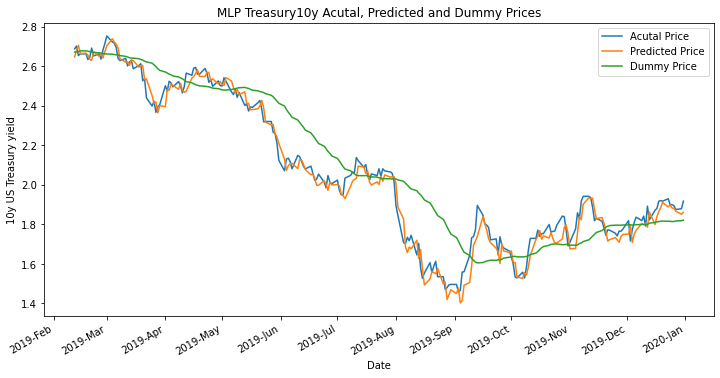

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

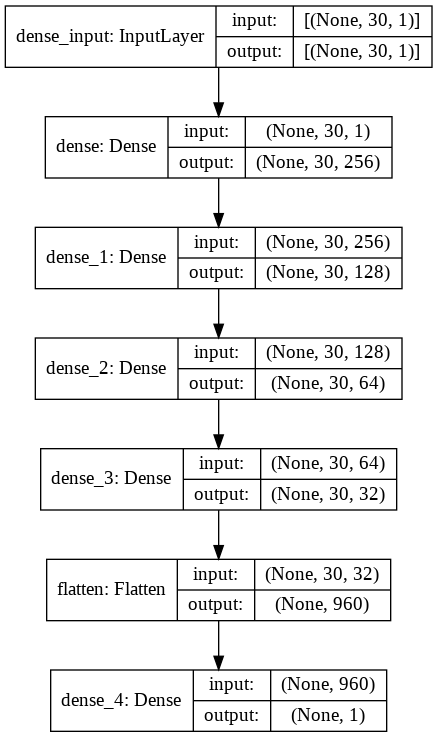

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.001739007716935881
RMSE:  0.04170141145016414
MAE:  0.03370940294685488
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [ ]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()